In [ ]:
!pip install ta
!pip install requests pandas numpy matplotlib ta
!pip install pandas numpy matplotlib scikit-learn requests scipy SQLAlchemy
!pip install statsmodels
!pip install dash
!pip freeze > requirements.txt
!conda install -c conda-forge ta-lib
!pip install sqlalchemy pyodbc
!pip install yfinance
!pip install streamlit
!pip install dash plotly

[*********************100%***********************]  1 of 1 completed


Error saving to SQL Server: (pyodbc.IntegrityError) ('23000', '[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Cannot insert an explicit value into a timestamp column. Use INSERT with a column list to exclude the timestamp column, or insert a DEFAULT into the timestamp column. (273) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Statement(s) could not be prepared. (8180)')
[SQL: INSERT INTO [BTC-USD_technical_analysis] ([Date], [Open], [High], [Low], [Close], [Adj Close], [Volume], returns, volatility, support, resistance, [SMA_14], [EMA_50], [BB_upper], [BB_middle], [BB_lower], [RSI], vwap, [fib_0.236], [fib_0.382], [fib_0. ... 6355 characters truncated ... ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('2024-10-16 00:00:00.000000 +00:00', 67053.1328125, 67053.1328125, 67053.1328125, 67053.1328125, 67053.1328125, 0, 0.0008399355874615377, 0.003912749250311085, 66789.7109

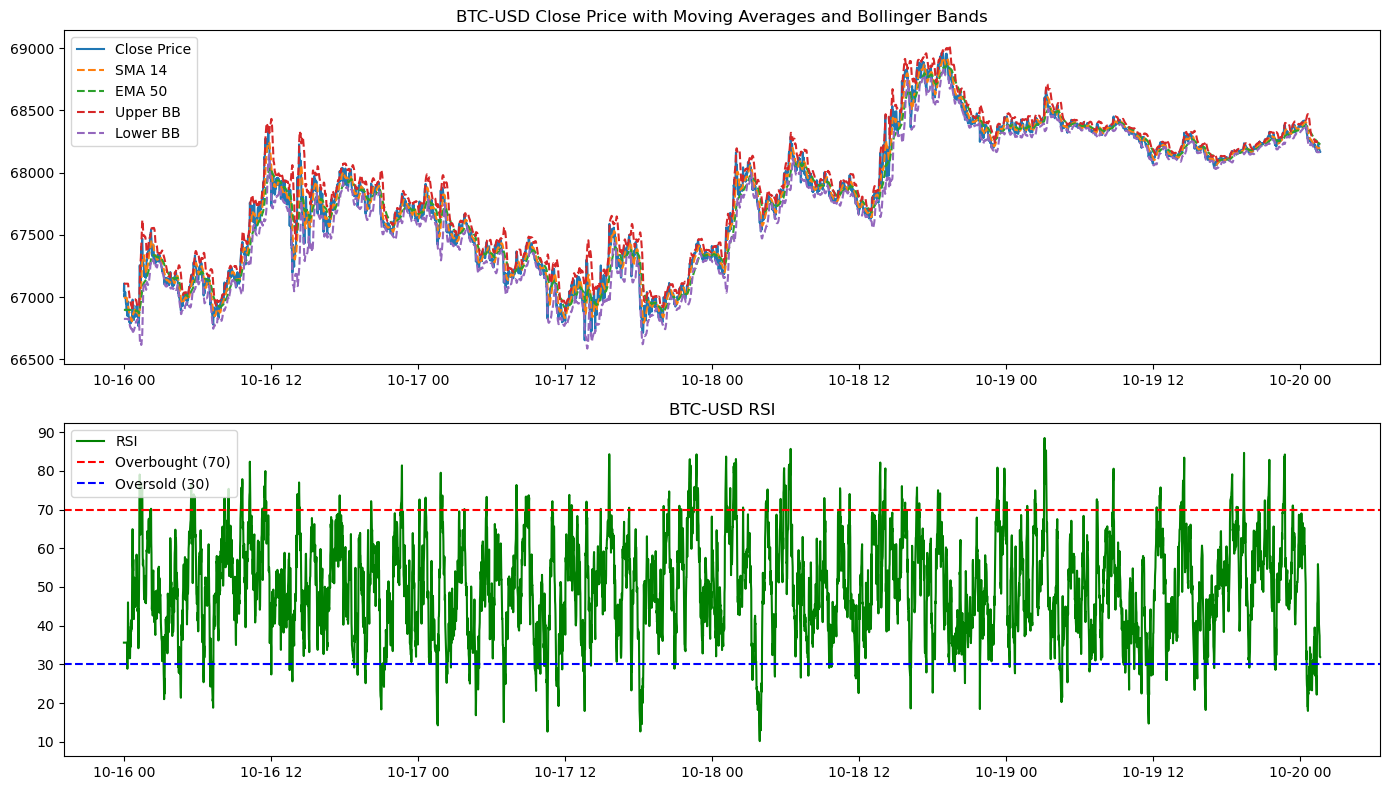

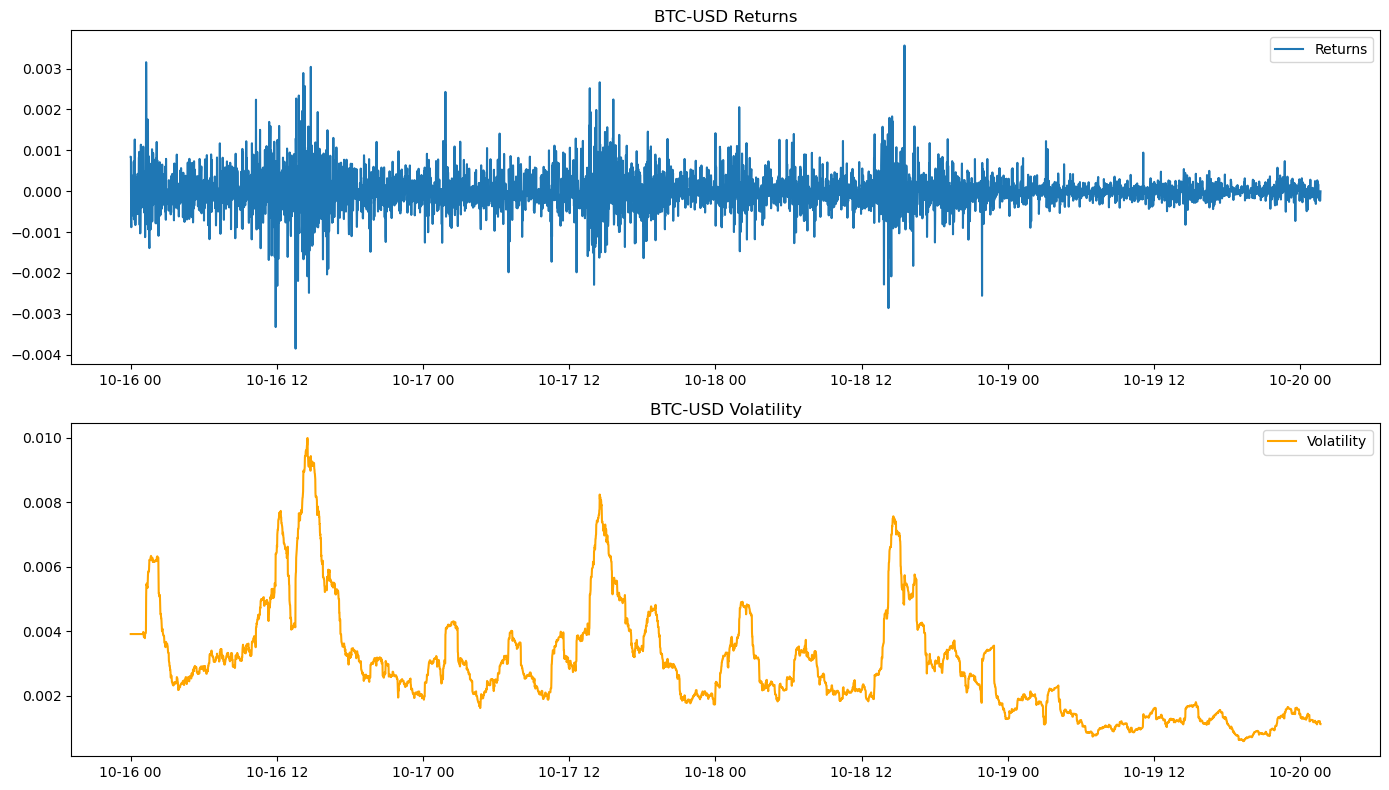

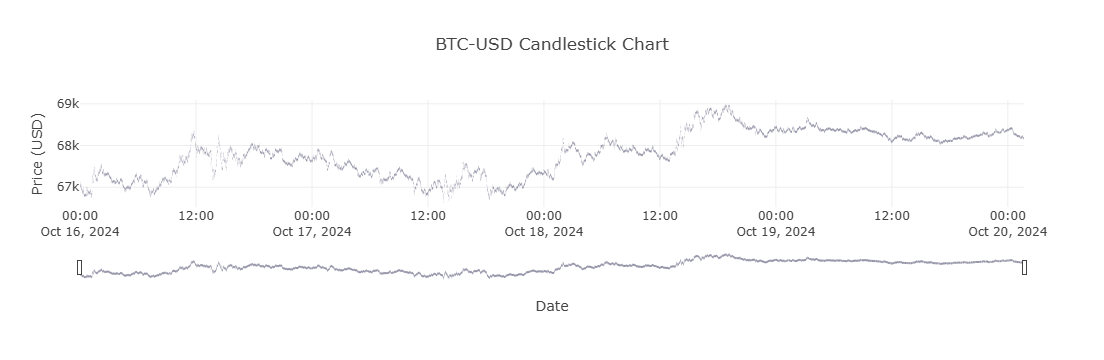

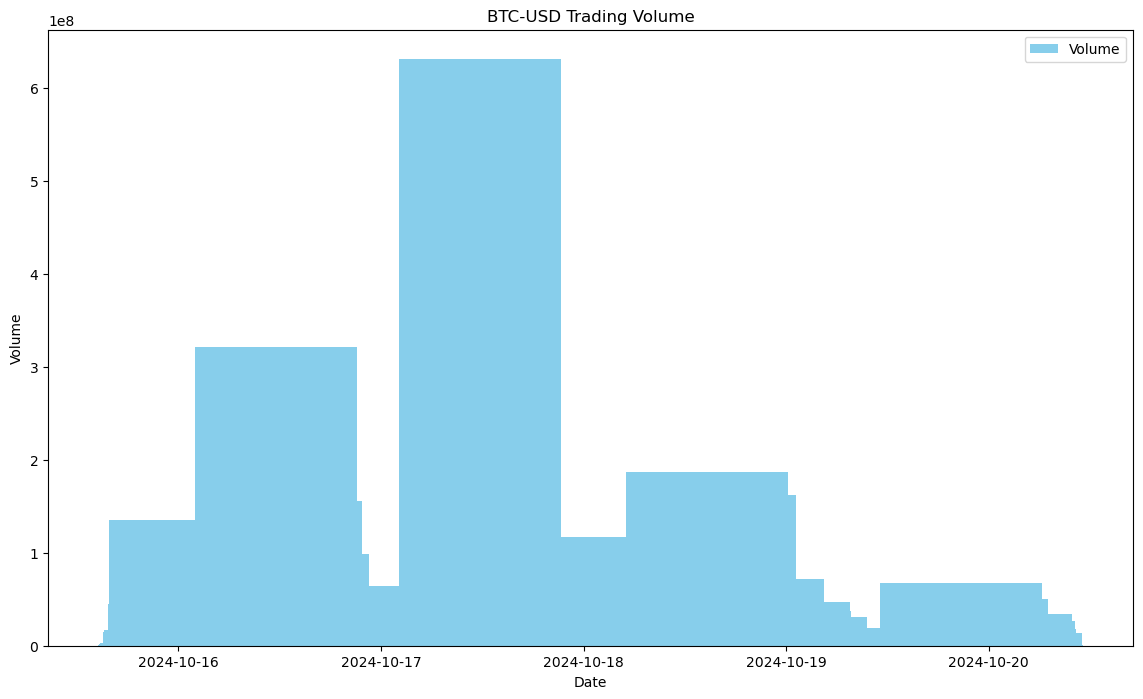

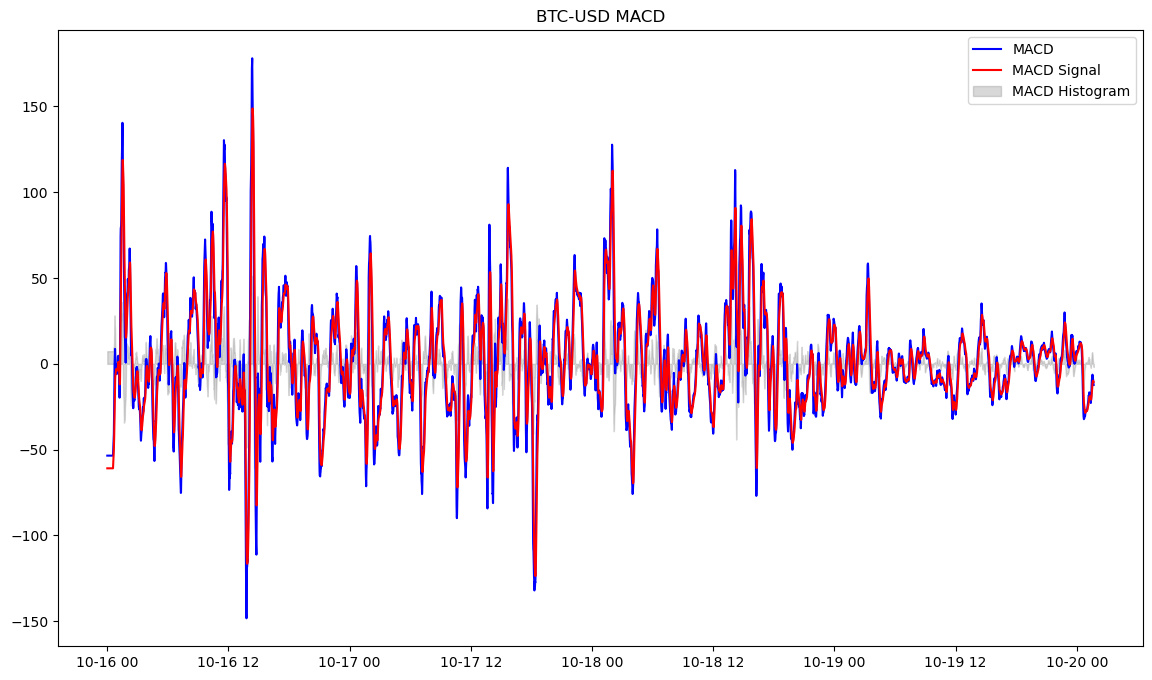

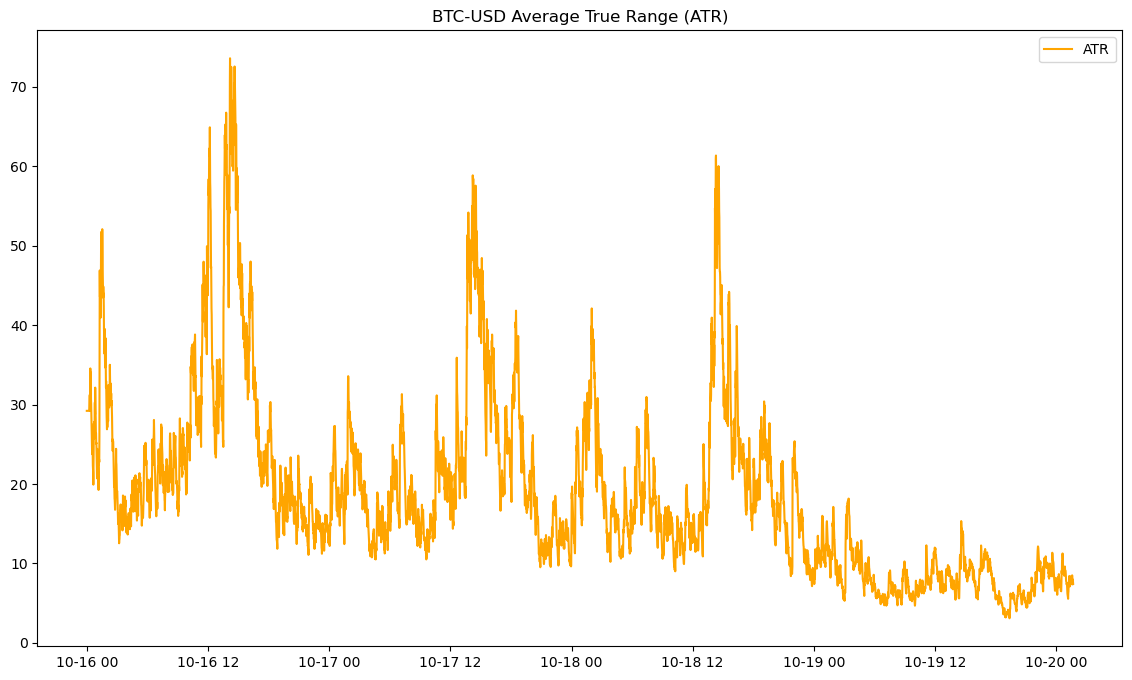

Data successfully saved to BTC-USD_technical_analysis in SQL Server.
SQL connection closed.


In [26]:
import pandas as pd
import numpy as np
import talib as ta
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sqlalchemy import create_engine
import urllib
import os  # Import the os module for checking file existence

# Database connection configuration
DATABASE_TYPE = 'mssql'
DBAPI = 'pyodbc'
SERVER = 'MARTIN'
DATABASE = 'crypto_data'
DRIVER = 'ODBC Driver 17 for SQL Server'

# Create a connection URI for SQLAlchemy
params = urllib.parse.quote_plus(f"DRIVER={DRIVER};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes")
DATABASE_URI = f"{DATABASE_TYPE}+{DBAPI}:///?odbc_connect={params}"

# Create SQLAlchemy engine
engine = create_engine(DATABASE_URI, echo=False)

# Download historical data
def get_crypto_data(symbol, period='7d', interval='1m'):
    data = yf.download(tickers=symbol, period=period, interval=interval)
    return data

# Calculate volatility
def calculate_volatility(df, window):
    df['returns'] = df['Close'].pct_change()
    df['volatility'] = df['returns'].rolling(window=window).std() * np.sqrt(window)
    return df

# Support and resistance levels
def find_support_resistance(df):
    df['support'] = df['Low'].rolling(window=60).min()
    df['resistance'] = df['High'].rolling(window=60).max()
    return df

# Moving Averages (SMA, EMA)
def calculate_moving_averages(df, short_window=14, long_window=50):
    df['SMA_14'] = ta.SMA(df['Close'], timeperiod=short_window)
    df['EMA_50'] = ta.EMA(df['Close'], timeperiod=long_window)
    return df

# Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std=2):
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.BBANDS(df['Close'], timeperiod=window, nbdevup=num_std, nbdevdn=num_std, matype=0)
    return df

# Relative Strength Index (RSI)
def calculate_rsi(df, period=14):
    df['RSI'] = ta.RSI(df['Close'], timeperiod=period)
    return df

# VWAP calculation
def calculate_vwap(df):
    df['vwap'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
    return df

# Fibonacci retracements (simplified)
def calculate_fibonacci_levels(df):
    max_price = df['Close'].max()
    min_price = df['Close'].min()
    diff = max_price - min_price
    df['fib_0.236'] = max_price - 0.236 * diff
    df['fib_0.382'] = max_price - 0.382 * diff
    df['fib_0.5'] = max_price - 0.5 * diff
    df['fib_0.618'] = max_price - 0.618 * diff
    df['fib_1'] = min_price
    return df

# Verify and clean data
def clean_data(df):
    df.dropna(how='all', inplace=True)
    df.ffill(inplace=True)  # Forward fill missing data
    df.bfill(inplace=True)  # Backward fill missing data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

# Save data to SQL Server
def save_to_sql(df, table_name):
    try:
        if df.empty:
            print("Data is empty after cleaning. Nothing to save.")
            return
        df.to_sql(table_name, con=engine, if_exists='replace', index_label='Date')
        print(f"Data successfully saved to {table_name} in SQL Server.")
    except Exception as e:
        print(f"Error saving to SQL Server: {e}")
    finally:
        engine.dispose()
        print("SQL connection closed.")

# CSV to SQL function
def csv_to_sql(file_name, table_name):
    try:
        df = pd.read_csv(file_name)
        df = clean_data(df)
        save_to_sql(df, table_name)
    except Exception as e:
        print(f"Error moving CSV data to SQL Server: {e}")

# Plot various data points
def plot_data(df, symbol):
    plt.figure(figsize=(14, 8))
    
    # Plot Close Price, Moving Averages, and Bollinger Bands
    plt.subplot(2, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['SMA_14'], label='SMA 14', linestyle='--')
    plt.plot(df['EMA_50'], label='EMA 50', linestyle='--')
    plt.plot(df['BB_upper'], label='Upper BB', linestyle='--')
    plt.plot(df['BB_lower'], label='Lower BB', linestyle='--')
    plt.title(f'{symbol} Close Price with Moving Averages and Bollinger Bands')
    plt.legend()
    
    # Plot RSI
    plt.subplot(2, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='green')
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
    plt.title(f'{symbol} RSI')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot Returns and Volatility
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['returns'], label='Returns')
    plt.title(f'{symbol} Returns')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(df.index, df['volatility'], label='Volatility', color='orange')
    plt.title(f'{symbol} Volatility')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot candlestick chart
def plot_candlestick(df, symbol):
    import plotly.graph_objects as go

    fig = go.Figure(data=[go.Candlestick(x=df.index,
                                          open=df['Open'],
                                          high=df['High'],
                                          low=df['Low'],
                                          close=df['Close'],
                                          name='Candlestick Chart')])

    fig.update_layout(title=f'{symbol} Candlestick Chart',
                      yaxis_title='Price (USD)',
                      xaxis_title='Date')
    fig.show()

# Calculate MACD
def calculate_macd(df):
    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    return df

# Plot MACD
def plot_macd(df, symbol):
    plt.figure(figsize=(14, 8))
    plt.plot(df['macd'], label='MACD', color='blue')
    plt.plot(df['macdsignal'], label='MACD Signal', color='red')
    plt.fill_between(df.index, df['macdhist'], color='gray', alpha=0.3, label='MACD Histogram')
    plt.title(f'{symbol} MACD')
    plt.legend()
    plt.show()

# Calculate Average True Range (ATR)
def calculate_atr(df, window):
    df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=window)
    return df

# Plot ATR
def plot_atr(df, symbol):
    plt.figure(figsize=(14, 8))
    plt.plot(df['ATR'], label='ATR', color='orange')
    plt.title(f'{symbol} Average True Range (ATR)')
    plt.legend()
    plt.show()

# Plot Volume
def plot_volume(df, symbol):
    plt.figure(figsize=(14, 8))
    plt.bar(df.index, df['Volume'], label='Volume', color='skyblue')
    plt.title(f'{symbol} Trading Volume')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()
    
# Example main function
def main():
    symbol = 'BTC-USD'
    period = '5d'
    interval = '1m'
    
    df = get_crypto_data(symbol, period, interval)
    if df.empty:
        print(f"No data found for {symbol}. Please check the period and interval.")
        return

    # Perform technical analysis
    df = calculate_volatility(df, window=60)
    df = find_support_resistance(df)
    df = calculate_moving_averages(df)
    df = calculate_bollinger_bands(df)
    df = calculate_rsi(df)
    df = calculate_vwap(df)
    df = calculate_fibonacci_levels(df)
    df = calculate_macd(df)
    df = calculate_atr(df, window=14)
    
    df = clean_data(df)
    save_to_sql(df, f"{symbol}_technical_analysis")

    file_name = f"{symbol}_technical_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df.to_csv(file_name)
    print(f"Data saved to {file_name}")

    # Visualize the data
    plot_data(df, symbol)
    plot_candlestick(df, symbol)
    plot_volume(df, symbol)
    plot_macd(df, symbol)
    plot_atr(df, symbol)

    if os.path.exists(file_name):
        csv_to_sql(file_name, f"{symbol}_technical_analysis")
    else:
        print(f"The file {file_name} does not exist. Please check the file path.")

if __name__ == "__main__":
    main()